In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import fbeta_score, precision_score
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import ndimage
import cv2

%matplotlib inline

/home/csci8523/attan005/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
source_dir = os.path.join('train-jpg', 'train-jpg')

In [3]:
x_train = []
y_train = []

train_data = pd.read_csv('train_v2.csv/train_v2.csv')

label_enum = 0
label_map = {}
labels = {}
for tags in train_data['tags']:
    classes = tags.split(" ")
    for label in classes:
        if label not in label_map:
            label_map[label] = label_enum
            labels[label_enum] = label
            label_enum = label_enum + 1
    if label_enum == 17:
        break
i =0
for image, tags in train_data.values:
    if i==1000:
        print("1000 image")
    i = i+1
    image_path = source_dir+"/"+image+".jpg"
    img = cv2.imread(image_path)
    img = cv2.resize(img, (139, 139))
    one_hot_labels = np.zeros(len(label_map))
    for label in tags.split(' '):
        one_hot_labels[label_map[label]] = 1
    x_train.append(img/255.0)
    y_train.append(one_hot_labels)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

1000 image
(40479, 139, 139, 3)
(40479, 17)


In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size =0.2)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size =0.5)
print(x_train.shape)
print(y_train.shape)

(32383, 139, 139, 3)
(32383, 17)


In [5]:
x_train_temp = x_train.copy()
y_train_temp = y_train.copy()
x_train_aug = []
y_train_aug = []
for i in range(17):
    if(np.sum(y_train_temp[:,i],axis=0)>y_train_temp.size/2):
        l = np.where(y_train_temp[:,i] == 0)[0]
        for j in range(1000):
            ind = np.random.choice(l)
            rnd = np.random.choice([1,2,3,4])
            if rnd == 1:
                img = cv2.flip(x_train[ind], 0)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 2:
                img = cv2.flip(x_train[ind], 1)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 3:
                img = ndimage.rotate(x_train[ind], 180)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            else:
                img = ndimage.rotate(x_train[ind], 90)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
    else:
        l = np.where(y_train_temp[:,i] == 1)[0]
        for j in range(1000):
            ind = np.random.choice(l)
            rnd = np.random.choice([1,2,3,4])
            if rnd == 1:
                img = cv2.flip(x_train[ind], 0)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 2:
                img = cv2.flip(x_train[ind], 1)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            elif rnd == 3:
                img = ndimage.rotate(x_train[ind], 180)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
            else:
                img = ndimage.rotate(x_train[ind], 90)
                x_train_aug.append(img)
                y_train_aug.append(y_train[ind])
y_train_aug = np.array(y_train_aug, np.uint8)
x_train_aug = np.array(x_train_aug, np.float32)
x_train = np.concatenate((x_train, x_train_aug))
y_train = np.concatenate((y_train, y_train_aug))
print(x_train.shape)
print(y_train.shape)

(49383, 139, 139, 3)
(49383, 17)


In [6]:
pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (139, 139, 3))
pretrained_model.trainable = False

In [7]:
input_layer = pretrained_model.input
model_output = pretrained_model.output
pooling_layer = GlobalAveragePooling2D()(model_output)
dense_layer = Dense(2048, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(17, activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [8]:
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128,verbose=2, epochs=10, shuffle=True)

Epoch 1/10
386/386 - 121s - loss: 0.1914 - accuracy: 0.8074 - val_loss: 0.1332 - val_accuracy: 0.8441 - 121s/epoch - 313ms/step
Epoch 2/10
386/386 - 117s - loss: 0.1584 - accuracy: 0.8042 - val_loss: 0.1303 - val_accuracy: 0.8496 - 117s/epoch - 303ms/step
Epoch 3/10
386/386 - 117s - loss: 0.1463 - accuracy: 0.7956 - val_loss: 0.1278 - val_accuracy: 0.8394 - 117s/epoch - 304ms/step
Epoch 4/10
386/386 - 117s - loss: 0.1367 - accuracy: 0.7849 - val_loss: 0.1284 - val_accuracy: 0.8249 - 117s/epoch - 303ms/step
Epoch 5/10
386/386 - 117s - loss: 0.1282 - accuracy: 0.7733 - val_loss: 0.1295 - val_accuracy: 0.8118 - 117s/epoch - 303ms/step
Epoch 6/10
386/386 - 117s - loss: 0.1202 - accuracy: 0.7620 - val_loss: 0.1299 - val_accuracy: 0.8132 - 117s/epoch - 303ms/step
Epoch 7/10
386/386 - 117s - loss: 0.1128 - accuracy: 0.7505 - val_loss: 0.1299 - val_accuracy: 0.7900 - 117s/epoch - 303ms/step
Epoch 8/10
386/386 - 117s - loss: 0.1056 - accuracy: 0.7364 - val_loss: 0.1305 - val_accuracy: 0.7831 - 

In [9]:
model.save_weights('model_aug_final.h5')

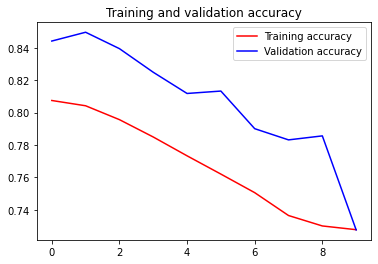

<Figure size 432x288 with 0 Axes>

In [10]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

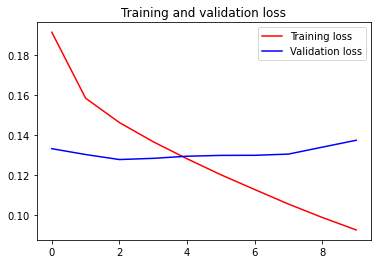

<Figure size 432x288 with 0 Axes>

In [11]:
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [12]:
y_pred = model.predict(x_test, batch_size = 128, verbose=2)

32/32 - 10s - 10s/epoch - 298ms/step


In [13]:
f2_score = fbeta_score(y_test, np.array(y_pred)>0.2, beta=2, average='samples')
print("F2 score:",f2_score)

F2 score: 0.8871878232951796


In [14]:
y_pred = np.array(y_pred)>0.2
total = np.sum(y_test,axis = 0)
total_train = np.sum(y_train,axis = 0)
tp = np.sum(y_test*y_pred,axis=0)
tn = np.sum((1-y_test)*(1-y_pred),axis=0)
fp = np.sum((1-y_test)*y_pred,axis=0)
fn = np.sum(y_test*(1-y_pred),axis=0)

d = {'Total':total,'TP':tp,'TN':tn,'FP':fp,'FN':fn, 'Total_train': total_train}
pd.DataFrame(d, index=label_map)


,Total,TP,TN,FP,FN,Total_train
haze,269,185,3612,167,84,3658
primary,3743,3721,165,140,22,45527
agriculture,1173,1050,2359,516,123,16443
clear,2814,2777,841,393,37,34422
water,772,649,2754,522,123,10333
habitation,376,231,3458,214,145,5964
road,793,664,2938,317,129,11862
cultivation,437,270,3157,454,167,7004
slash_burn,30,2,3988,30,28,1260
cloudy,213,196,3731,104,17,2659


In [15]:
sum = np.add(tp, fp)
precision = np.divide(tp, sum)
recall = np.divide(tp, np.add(tp, fn))
accuracy = np.divide(np.add(tp, tn), np.add(fp, np.add(fn, np.add(tp, tn))))
f1 = 2*(np.divide(np.multiply(precision, recall), np.add(precision, recall)))
f2 = (np.divide(5*np.multiply(precision, recall), np.add(4*precision, recall)))
evalution_metrics = {'Accuracy':accuracy,'Precision':precision,'Recall':recall,'f1':f1, 'f2': f2}
pd.DataFrame(evalution_metrics, index=label_map)

,Accuracy,Precision,Recall,f1,f2
haze,0.937994,0.525568,0.687732,0.595813,0.647759
primary,0.959980,0.963740,0.994122,0.978695,0.987894
agriculture,0.842144,0.670498,0.895141,0.766703,0.838926
clear,0.893775,0.876025,0.986851,0.928142,0.962498
water,0.840662,0.554227,0.840674,0.668039,0.761916
habitation,0.911314,0.519101,0.614362,0.562728,0.592612
road,0.889822,0.676860,0.837327,0.748591,0.799422
cultivation,0.846591,0.372928,0.617849,0.465116,0.546117
slash_burn,0.985672,0.062500,0.066667,0.064516,0.065789
cloudy,0.970109,0.653333,0.920188,0.764133,0.850694


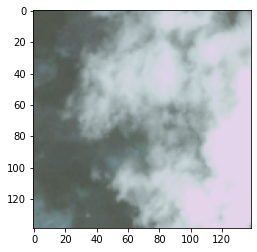

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True False False False False False False False  True  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary cloudy partly_cloudy 


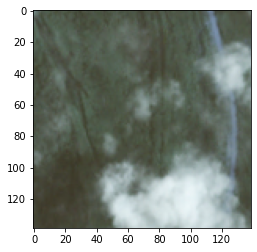

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False False False  True  True False False  True False
 False False False False False]
True label
primary water road partly_cloudy 
Predicted
primary agriculture road cultivation partly_cloudy 


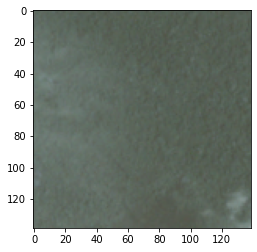

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True False  True False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary clear partly_cloudy 


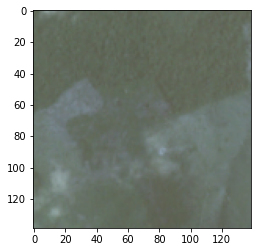

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary agriculture partly_cloudy 
Predicted
primary agriculture partly_cloudy 


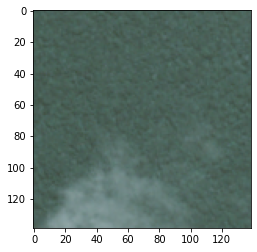

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


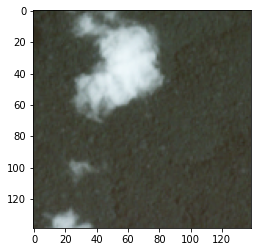

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True False False  True False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary water partly_cloudy 


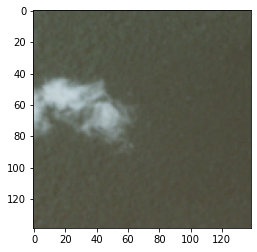

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


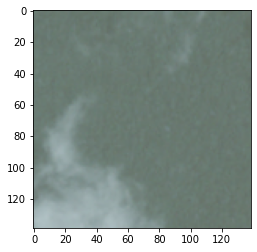

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture partly_cloudy 


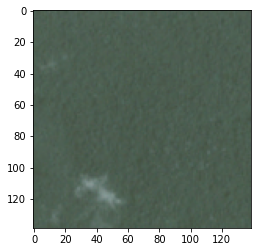

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture partly_cloudy 


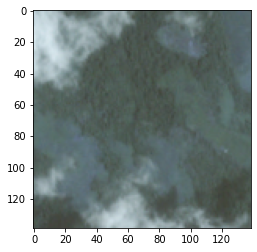

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False  True  True False  True False False  True False
 False False False False False]
True label
primary agriculture cultivation partly_cloudy 
Predicted
primary agriculture water habitation cultivation partly_cloudy 


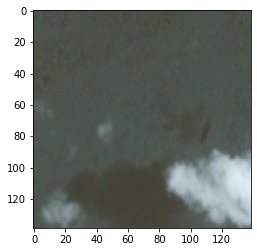

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False  True False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture water partly_cloudy 


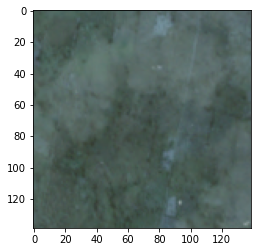

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True  True False  True  True  True False False  True False
 False False False False False]
True label
primary agriculture habitation road partly_cloudy 
Predicted
primary agriculture clear habitation road cultivation partly_cloudy 


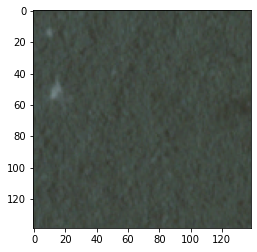

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False  True False False False False False False False False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary clear 


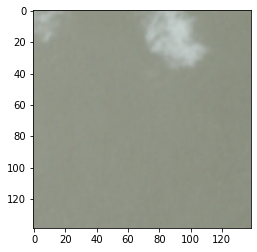

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


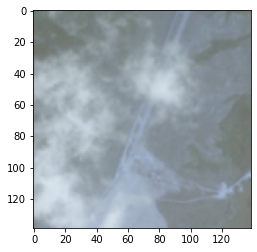

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True False False  True  True False False False  True False
 False False False False False]
True label
primary agriculture water road partly_cloudy 
Predicted
primary agriculture habitation road partly_cloudy 


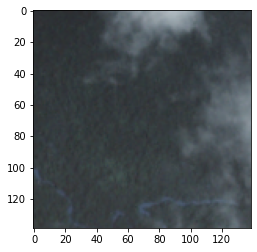

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True  True False  True False False False False False  True False
 False False False False False]
True label
primary water partly_cloudy 
Predicted
primary agriculture water partly_cloudy 


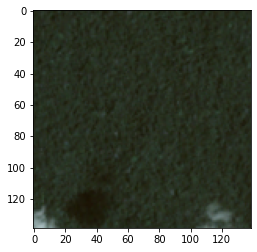

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True  True  True False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture clear partly_cloudy 


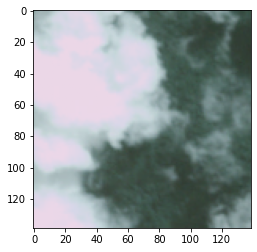

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True False False False False False False False  True  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary cloudy partly_cloudy 


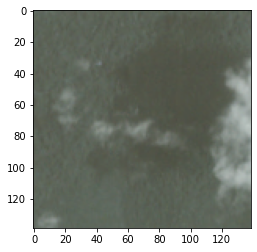

1/1 - 0s - 22ms/epoch - 22ms/step
[False  True False False  True False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary water partly_cloudy 


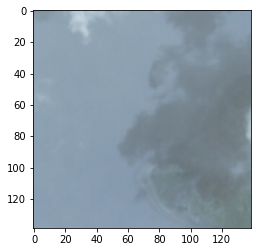

1/1 - 0s - 21ms/epoch - 21ms/step
[False  True  True  True  True False  True False False False  True False
 False False False False False]
True label
primary agriculture water partly_cloudy 
Predicted
primary agriculture clear water road partly_cloudy 


In [16]:
j = 0
k=0
while(j<20 and k<len(x_test)):
    img = x_test[k]
    tags = ''
    y = y_test[k]
    cloudy = False
    for i in range(len(y)):
        if y[i] == 1:
            tags = tags + labels[i] + ' '
            if labels[i] == 'partly_cloudy':
                cloudy = True
    if cloudy:
        plt.imshow(img)
        plt.show()
        img = np.expand_dims(img, axis = 0)
        y = model.predict(img, batch_size = 1, verbose=2)
        y_pred = np.array(y > 0.2).reshape(-1)
        print(y_pred)
        preds = ""
        for i in range(len(y_pred)):
            if y_pred[i] != 0:
                preds = preds+labels[i]+" "
        print('True label')
        print(tags)
        print('Predicted')
        print(preds)
        j+=1
    k=k+1